## Imports

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import os
import pickle
import imghdr
import cv2
from PIL import Image

import time
from matplotlib import pyplot as plt
from plotly import express as px

In [ ]:
def results(pred):

    y_hat = np.argmax(pred, axis=1)

#     y_true = ['healthy', 'healthy', 'healthy']

    # get the meaning of the labels generated from tensorflow
    data = tf.keras.utils.image_dataset_from_directory('../data_plant_disease/train_images/')
    class_names = data.class_names
    class_names_map = {i:class_names[i] for i in range(12)}

    y_hat = [class_names_map[i] for i in y_hat]

    return y_hat

## Load data

In [2]:
img_name_list_train = os.listdir('../data_plant_disease/train_images/')
img_name_list_test = os.listdir('../data_plant_disease/test_images/')

train_labels = pd.read_csv('../data_plant_disease/train.csv')

## Check class balance

In [3]:
count_class = train_labels.groupby('labels').count().reset_index().sort_values('image')

px.bar(count_class, y='labels',x='image')

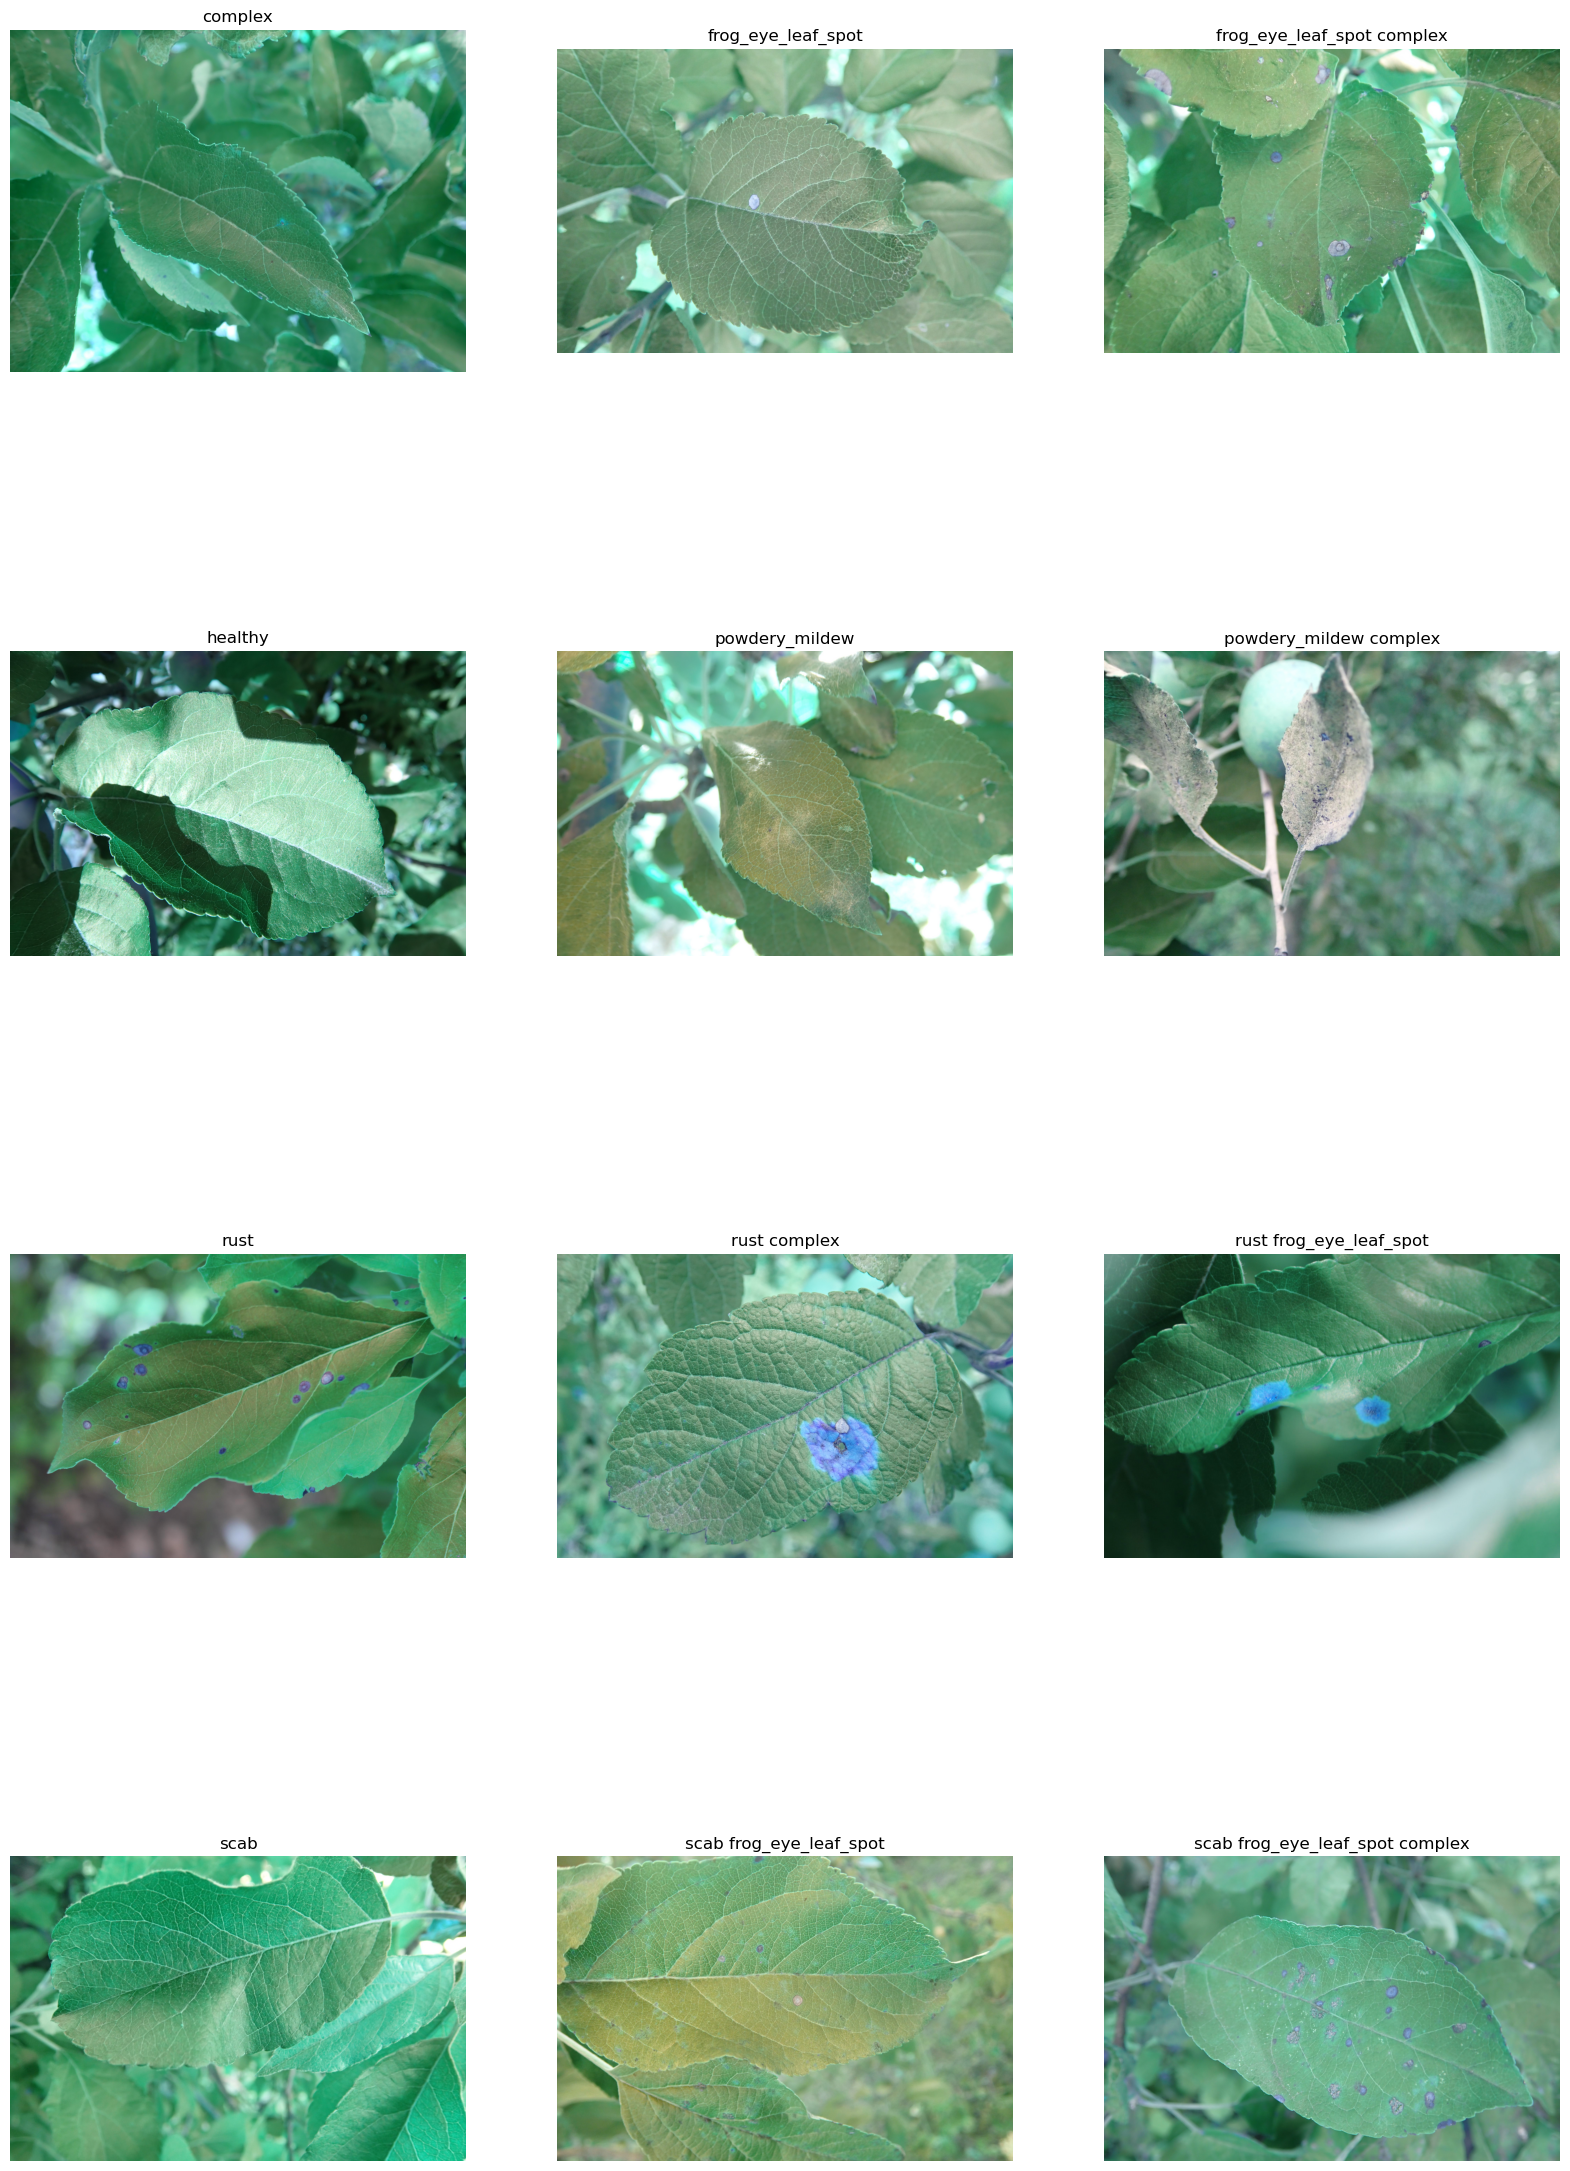

In [4]:
labels = os.listdir('../data_plant_disease/train_images')

# Set up the subplot grid
fig, ax = plt.subplots(4, 3, figsize=(20,30))

# Flatten the subplot array to simplify iteration
ax = ax.flatten()

# Plot each image in its own subplot
for i, ax_i in enumerate(ax):
    rand_img = os.listdir(f'../data_plant_disease/train_images/{labels[i]}')[10]
    image_path = f'../data_plant_disease/train_images/{labels[i]}/{rand_img}'
    img = cv2.imread(image_path)
    ax_i.imshow(img)
    ax_i.set_title(labels[i])
    ax_i.axis('off')

## Create one folder per class and move the images

In [5]:
# import os
# import pandas as pd

# path = '../data_plant_disease/'

# # Ler o arquivo CSV
# df = pd.read_csv(path + "train.csv")

# # Obter o nome das classes únicas
# labels = df['labels'].unique()

# # Criar uma pasta para cada classe
# for label in labels:
#     os.makedirs(label, exist_ok=True)
#     os.rename(os.path.join(label), f'../data_plant_disease/train_images/{label}')

# # move to train_images
# path = path + 'train_images/'

# # Mover as imagens para as pastas correspondentes
# for index, row in df.iterrows():
#     os.rename(path + row['image'], path + f"{row['labels']}/{row['image']}")

## Create keras dataset

In [6]:
data = tf.keras.utils.image_dataset_from_directory('../data_plant_disease/train_images/')

data = data.map(lambda x, y: (x/255, y))

Found 18632 files belonging to 12 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

In [9]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [10]:
# label
batch[1]

array([ 1,  1,  4,  3,  2,  9,  3,  4,  1,  0,  9, 10,  3,  6,  3,  4,  1,
        1,  9,  4,  0,  1,  3,  6,  9,  9,  9, 11,  3,  9,  3,  3])

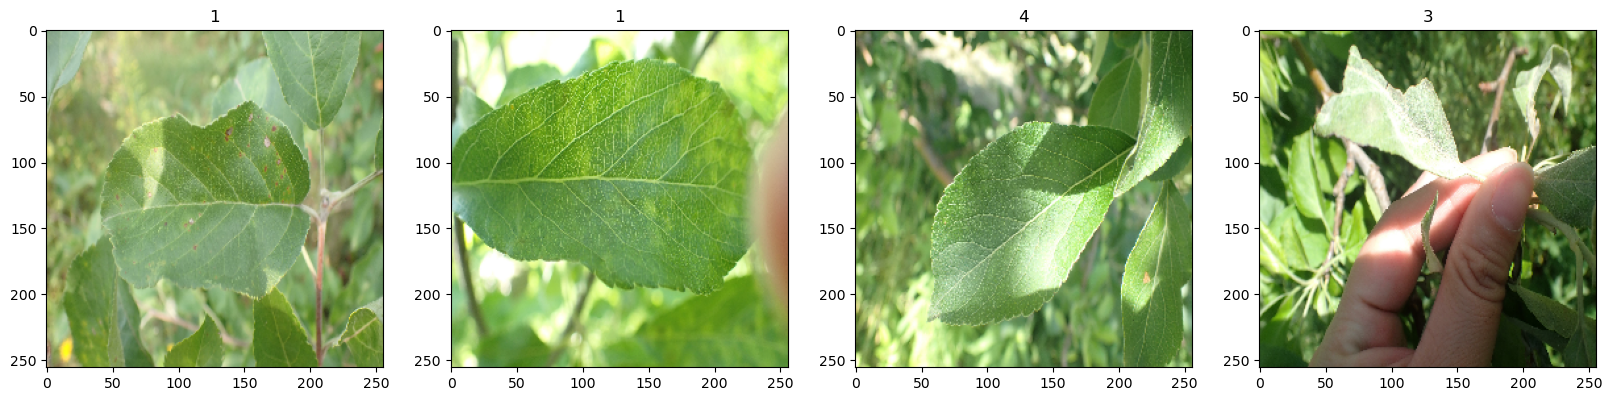

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][4:8]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Split Data

In [12]:
train_size = int(len(data)*.7) + 1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)


In [13]:
# verify if the size of all the data matches
train_size + test_size + val_size == len(data)

True

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Preprocessing

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
# classes with few examples
count_by_label = train_labels.groupby('labels').count().reset_index().sort_values('image')
few_examples = np.array(count_by_label.head()['labels'])

In [68]:
count = 0

for classe in few_examples[:]:
    
    print(classe)
    
    # get the folder of the class
    path = f"../data_plant_disease/train_images/{classe}"
    while len(os.listdir(path))<=600:
        
        img_list = []
        
        count+=1
        print(count)
        
        
        for i in range(len(os.listdir(path))):

            img_name = os.listdir(path)[i]
            img = cv2.imread("../data_plant_disease/train_images/{}/{}".format(classe, img_name))
            img = tf.image.resize(img, (256,256))
            np_img = img.numpy()  # convert tensor to numpy array
            np_img = np.uint8(np_img)  # convert data type to uint8
            img_list.append(np_img)


        img_list = np.array(img_list)/255

        # data agumentation fit
        datagen.fit(img_list)
        augmented_data = datagen.flow(img_list, batch_size=32)

        # Get the number of batches
        n_batches = len(augmented_data)

        # Loop over the batches
        for i in range(n_batches):
            X_batch= next(augmented_data)  # get the next batch of images

            for j in range(X_batch.shape[0]):
                np_img = X_batch[j]
                np_img = np.uint8(np_img * 255)  # convert data type back to uint8
                img = Image.fromarray(np_img)

                # Save the Image object as a JPEG image in the corresponding class folder
                img.save(f"{path}/aug_img_{count}_{i}_{j}.jpeg", "JPEG")



powdery_mildew complex
rust complex
1
2
3
rust frog_eye_leaf_spot
4
5
6
frog_eye_leaf_spot complex
7
8
scab frog_eye_leaf_spot complex
9
10


## Train, Val, Test Split

In [73]:
data = tf.keras.utils.image_dataset_from_directory('../data_plant_disease/train_images/')

data = data.map(lambda x, y: (x/255, y))

train_size = int(len(data)*.7) 
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

Found 21863 files belonging to 12 classes.


In [75]:
# verify if the size of all the data matches
print(train_size + test_size + val_size == len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

True


## Build Model

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

# add layers
model.add(Conv2D(16, (3,3), strides=1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), strides=1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Change the number of units to 12
model.add(Dense(256, activation = 'relu'))

# Add a final dense layer with 12 units and a softmax activation function for classification
model.add(Dense(12, activation='softmax'))

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

logdir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs = 5, validation_data=val, callbacks=[tensorboard_callback])

with open("history.pkl", "wb") as f:
    pickle.dump(hist.history, f)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

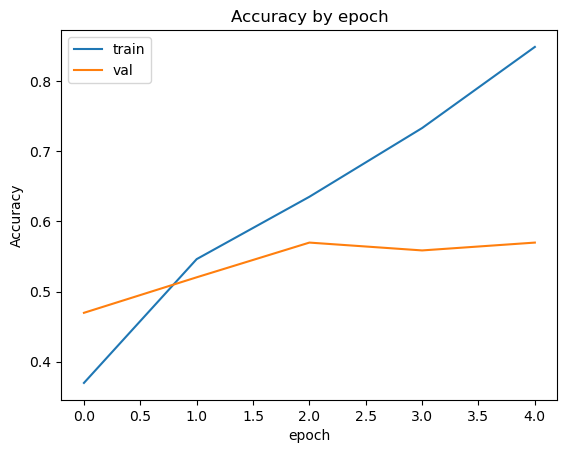

In [100]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.title('Accuracy by epoch')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

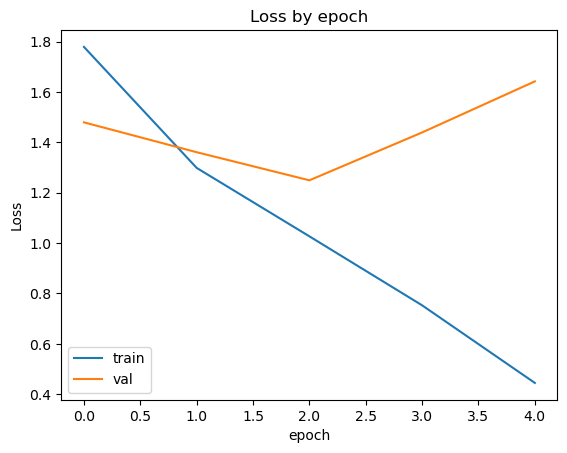

In [101]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train', 'val'])
plt.title('Loss by epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [113]:
model.save('model.h5')

In [62]:
augmented_data = datagen.flow(img_list, batch_size=32)


In [77]:
classes = os.listdir('../data_plant_disease/train_images/')

In [81]:
len(os.listdir('../data_plant_disease/train_images/healthy'))

4624

In [85]:
new_sizes = pd.DataFrame()
new_sizes['class'] = classes

In [86]:
for i, classe in enumerate(classes):
    
    new_sizes.loc[i, 'lenght'] = len(os.listdir(f'../data_plant_disease/train_images/{classe}'))

In [90]:
px.bar(new_sizes.sort_values('lenght') , y = 'class', x = 'lenght')

In [103]:
pred = model.predict(test)

69/69 [==============================] - 212s 396ms/step


In [ ]:
y_hat = np.argmax(pred, axis=1)